In [1]:
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import EpsilonGreedyHead
# import d3rlpy algorithms
from d3rlpy.algos import DoubleDQNConfig
from d3rlpy.dataset import create_fifo_replay_buffer
from d3rlpy.algos import ConstantEpsilonGreedy
# import rtbgym and gym
import d3rlpy
import os
import rtbgym
import gym
import torch
# random state
random_state = 12345
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# (0) Setup environment
env = gym.make("CartPole-v1")

load_path = "/Users/chanb/research/ualberta/understanding_rl_qf/ope/d3rlpy_logs/DoubleDQN_online_20241104073548/model_100000.d3"

if os.path.isfile(load_path):
    ddqn = d3rlpy.load_learnable(load_path)
else:
    # (1) Learn a baseline policy in an online environment (using d3rlpy)
    # initialize the algorithm
    ddqn = DoubleDQNConfig().create(device=device)
    # train an online policy
    # this takes about 5min to compute
    ddqn.fit_online(
        env,
        buffer=create_fifo_replay_buffer(limit=10000, env=env),
        explorer=ConstantEpsilonGreedy(epsilon=0.3),
        n_steps=100000,
        n_steps_per_epoch=1000,
        update_start_step=1000,
    )

In [7]:
# (2) Generate a logged dataset
# convert the ddqn policy into a stochastic behavior policy
behavior_policy = EpsilonGreedyHead(
    ddqn,
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)
# initialize the dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=getattr(env, "step_per_episode", env._max_episode_steps),
)
# the behavior policy collects some logged data
train_logged_dataset = dataset.obtain_episodes(
  behavior_policies=behavior_policy,
  n_trajectories=10000,
  random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
  behavior_policies=behavior_policy,
  n_trajectories=10000,
  random_state=random_state + 1,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/chanb/research/ualberta/understanding_rl_qf/rl/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/chanb/research/ualberta/understanding_rl_qf/rl/.venv/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
import dill

offline_dataset_path = "offline_data-cartpole.dill"
if os.path.isfile(offline_dataset_path):
    with open(offline_dataset_path, "rb") as f:
        result = dill.load(f)
        train_logged_dataset = result["train_logged_dataset"]
        test_logged_dataset = result["test_logged_dataset"]
else:
    dill.dump(
        dict(
            train_logged_dataset=train_logged_dataset,
            test_logged_dataset=test_logged_dataset,
        ),
        open("offline_data-cartpole.dill", "wb"),
    )

## Offline RL

In [9]:
# implement an offline RL procedure using SCOPE-RL and d3rlpy

# import d3rlpy algorithms
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQLConfig

# (3) Learning a new policy from offline logged data (using d3rlpy)
# convert the logged dataset into d3rlpy's dataset format
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
)

offline_load_path = "/Users/chanb/research/ualberta/understanding_rl_qf/ope/d3rlpy_logs/DiscreteCQL_20241104080702/model_10000.d3"
if os.path.isfile(offline_load_path):
    cql = d3rlpy.load_learnable(offline_load_path)
else:
    # initialize the algorithm
    cql = DiscreteCQLConfig().create(device=device)
    # train an offline policy
    cql.fit(
        offlinerl_dataset,
        n_steps=10000,
    )


2024-11-06 13:05.31 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-11-06 13:05.31 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-11-06 13:05.37 [info     ] Action size has been automatically determined. action_size=2


## OPE

In [ ]:
# implement a basic OPE procedure using SCOPE-RL

# import SCOPE-RL modules
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as OPE
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.discrete import DoublyRobust as DR

# (4) Evaluate the learned policy in an offline manner
# we compare ddqn, cql, and random policy
cql_ = EpsilonGreedyHead(
    base_policy=cql,
    n_actions=env.action_space.n,
    name="cql",
    epsilon=0.0,
    random_state=random_state,
)
ddqn_ = EpsilonGreedyHead(
    base_policy=ddqn,
    n_actions=env.action_space.n,
    name="ddqn",
    epsilon=0.0,
    random_state=random_state,
)
random_ = EpsilonGreedyHead(
    base_policy=ddqn,
    n_actions=env.action_space.n,
    name="random",
    epsilon=1.0,
    random_state=random_state,
)
evaluation_policies = [cql_, ddqn_, random_]
# create input for the OPE class
prep = CreateOPEInput(
    env=env,
)
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)
# initialize the OPE class
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR()],
)
# perform OPE and visualize the result
ope.visualize_off_policy_estimates(
    input_dict,
    random_state=random_state,
    sharey=True,
)

## My Code

In [10]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import optax

from functools import partial
from gym.spaces import Dict, Box
from tqdm.notebook import tqdm

from common_models import Model, get_activation
from layer_modules import MLPModule
from learning_utils import make_update_function

from constants import *

In [11]:
class MLPCritic(Model):
    def __init__(
        self,
        num_models,
        observation_space,
        action_space,
        num_outputs=1,
        use_batch_norm=False,
        use_layer_norm=False,
    ):
        self.num_models = num_models
        # Wide critic
        self.mlp = MLPModule(
            layers=[2048, 2048, num_outputs],
            activation=get_activation(CONST_RELU),
            output_activation=get_activation(CONST_IDENTITY),
            use_batch_norm=use_batch_norm,
            use_layer_norm=use_layer_norm,
            use_bias=True,
        )

        self._observation_space = observation_space
        self._action_space = action_space

        self.forward = jax.jit(
            self.make_forward([CONST_BATCH_STATS]), static_argnames=[CONST_EVAL]
        )
        self.intermediates = jax.jit(
            self.make_forward(["intermediates"], True), static_argnames=[CONST_EVAL]
        )

    def init(self, model_key):
        sample_obs = self._observation_space.sample()
        sample_act = self._action_space.sample()
        model_keys = jrandom.split(model_key, self.num_models)
        params = jax.vmap(self._init, in_axes=[0, None, None])(
            model_keys, sample_obs, sample_act
        )
        return params

    def _init(self, model_key, sample_obs, sample_act):
        mlp_key = jrandom.split(model_key)[0]

        sample_latent = jnp.concatenate(
            (
                *[val.astype(float) for key, val in sample_obs.items()],
                sample_act,
            ),
            axis=-1,
        )

        mlp_params = self.mlp.init(mlp_key, sample_latent[None], eval=True)

        params = {
            CONST_MLP: mlp_params,
        }

        return params

    def make_forward(
        self,
        mutable,
        capture_intermediates=False,
    ):
        def forward(
            params,
            obs,
            act,
            eval=False,
            **kwargs,
        ):
            # NOTE: Assume batch size is first dim
            latent = jnp.concatenate(
                (
                    *[val.astype(float) for key, val in obs.items()],
                    act,
                ),
                axis=-1,
            )
            (out, mlp_updates) = self.mlp.apply(
                params[CONST_MLP],
                latent,
                eval=eval,
                mutable=mutable,
                capture_intermediates=capture_intermediates,
            )
            return out, {
                CONST_MLP: mlp_updates,
            }

        return forward

    def update_batch_stats(self, params, batch_stats):
        if CONST_BATCH_STATS in batch_stats[CONST_MLP]:
            params[CONST_MLP][CONST_BATCH_STATS] = batch_stats[CONST_MLP][
                CONST_BATCH_STATS
            ]
        return params

In [12]:
qf = MLPCritic(1, Dict({"observation": env.observation_space}), Box(np.zeros(env.action_space.n), np.ones(env.action_space.n)), use_batch_norm=False)

/Users/chanb/research/ualberta/understanding_rl_qf/rl/.venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [65]:
params = qf.init(jrandom.PRNGKey(1))

In [14]:
lr = 3e-4
num_epochs = 100000
log_interval = 100
batch_size = 32
discount_factor = 0.99

sample_seed = 42
learner_seed = 42

In [66]:
qf_opt = optax.adam(lr)
opt_state = qf_opt.init(params)

In [67]:
model_dict = {
    CONST_MODEL: {CONST_QF: params},
    CONST_OPT_STATE: {CONST_QF: opt_state},
}
optimizers = {
    CONST_QF: qf_opt,
}

In [68]:
sample_key = jrandom.PRNGKey(sample_seed)
learner_key = jrandom.PRNGKey(learner_seed)

In [69]:
def scan_monte_carlo_returns(rews, dones, gamma):
    def _returns(
        next_val, transition
    ):
        rew, done = transition
        val = next_val * gamma * (1 - done) + rew
        return val, val

    return jax.lax.scan(
        _returns, 0, np.concatenate((rews, dones), axis=-1), len(rews), reverse=True
    )[1]

In [70]:
def make_step(loss, model_update, optimizer):
    def _step(model_dict, batch, keys, *args, **kwargs):
        (agg_loss, aux), grads = jax.value_and_grad(loss, has_aux=True)(
            model_dict[CONST_MODEL][CONST_QF],
            batch,
        )

        qf_params, qf_opt_state = model_update(
            optimizer[CONST_QF],
            grads,
            model_dict[CONST_OPT_STATE][CONST_QF],
            model_dict[CONST_MODEL][CONST_QF],
            aux[CONST_UPDATES],
        )

        aux[CONST_AGG_LOSS] = agg_loss

        return {
            CONST_MODEL: {CONST_QF: qf_params},
            CONST_OPT_STATE: {CONST_QF: qf_opt_state},
        }, aux

    return jax.jit(_step)

In [71]:
def make_sarsa_loss(discount_factor, qf):
    def sarsa_loss(qf_params, batch):
        all_q_preds, updates = jax.vmap(
            partial(qf.forward, eval=False), in_axes=[0, None, None]
        )(
            qf_params,
            jax.tree_util.tree_map(
                lambda *args: jnp.concatenate(args, axis=0),
                batch["observation"],
                batch["next_observation"],
            ),
            jnp.concatenate(
                (batch["action"], batch["next_action"]),
                axis=0,
            ),
        )

        all_q_preds_min = jax.lax.stop_gradient(jnp.min(all_q_preds, axis=0))
        curr_q_preds_min, next_q_preds_min = jnp.split(all_q_preds_min, 2)
        curr_q_preds, _ = jnp.split(all_q_preds, 2, axis=1)

        # Compute min. clipped TD error
        next_vs = next_q_preds_min
        curr_q_targets = (
            batch["reward"]
            + discount_factor * (1 - batch["terminal"]) * next_vs
        )
        td_errors = (curr_q_preds - curr_q_targets[None]) ** 2
        return jnp.mean(td_errors), {
            CONST_UPDATES: updates,
        }

    return jax.jit(sarsa_loss)

def make_mc_loss(discount_factor, qf):
    def mc_loss(qf_params, batch):
        all_q_preds, updates = jax.vmap(
            partial(qf.forward, eval=False), in_axes=[0, None, None]
        )(
            qf_params,
            jax.tree_util.tree_map(
                lambda *args: jnp.concatenate(args, axis=0),
                batch["observation"],
                batch["next_observation"],
            ),
            jnp.concatenate(
                (batch["action"], batch["next_action"]),
                axis=0,
            ),
        )

        curr_q_preds, _ = jnp.split(all_q_preds, 2, axis=1)

        # Compute min. clipped TD error
        curr_q_targets = batch["return"]
        td_errors = (curr_q_preds - curr_q_targets[None]) ** 2
        return jnp.mean(td_errors), {
            CONST_UPDATES: updates,
        }

    return jax.jit(mc_loss)

In [77]:
loss_name = "sarsa"
loss_name = "mc"

if loss_name == "sarsa":
    loss_fn = make_sarsa_loss(discount_factor, qf)
elif loss_name == "mc":
    loss_fn = make_mc_loss(discount_factor, qf)
else:
    raise NotImplementedError
step = make_step(loss_fn, make_update_function(qf), optimizers)

In [73]:
losses_mean = []
losses_std = []
losses = []

train_rets = scan_monte_carlo_returns(train_logged_dataset["reward"][..., None], train_logged_dataset["terminal"][..., None], discount_factor)
for epoch_i in tqdm(range(num_epochs)):
    learner_key = jrandom.fold_in(learner_key, epoch_i)
    sample_key = jrandom.fold_in(sample_key, epoch_i)
    sample_inds = jrandom.randint(
        sample_key,
        shape=(batch_size,),
        minval=0,
        maxval=train_logged_dataset["size"]
    )

    next_sample_inds = jnp.clip(sample_inds + 1, min=0, max=train_logged_dataset["size"] - 1)
    batch = {
        "observation": {"observation": train_logged_dataset["state"][sample_inds]},
        "next_observation": {"observation": train_logged_dataset["state"][next_sample_inds]},
        "action": np.eye(train_logged_dataset["n_actions"])[train_logged_dataset["action"][sample_inds]],
        "next_action": np.eye(train_logged_dataset["n_actions"])[train_logged_dataset["action"][next_sample_inds]],
        "reward": train_logged_dataset["reward"][sample_inds],
        "terminal": train_logged_dataset["terminal"][sample_inds],
        "return": train_rets[sample_inds][..., None],
    }

    model_dict, aux = step(model_dict, batch, learner_key)
    losses.append(aux[CONST_AGG_LOSS])

    if (epoch_i + 1) % log_interval == 0:
        losses_mean.append(np.mean(losses))
        losses_std.append(np.std(losses))
        losses = []


  0%|          | 0/100000 [00:00<?, ?it/s]

## Plotting

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

(-1.0, 100.0)

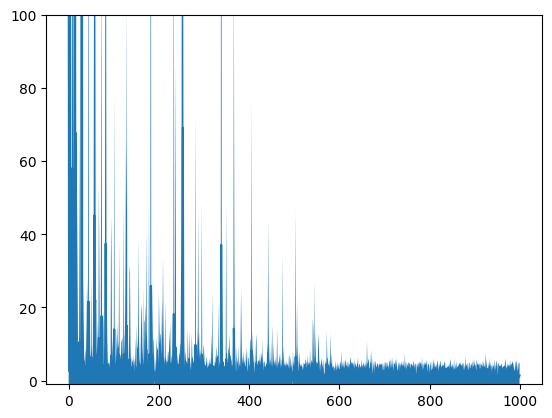

In [24]:
losses_mean = np.array(losses_mean)
losses_std = np.array(losses_std)

x_axis = np.arange(len(losses_mean))
plt.plot(x_axis, losses_mean)
plt.fill_between(x_axis, losses_mean - losses_std, losses_mean + losses_std)
plt.ylim(-1, 100.0)

In [78]:
save_path = f"{loss_name}.dill"

dill.dump(
    model_dict,
    open(save_path, "wb")
)

In [62]:
test_rets = scan_monte_carlo_returns(test_logged_dataset["reward"][..., None], test_logged_dataset["terminal"][..., None], discount_factor)

In [63]:
value_errors = []
batch_i = 0
while True:
    start_ind = batch_i * batch_size
    end_ind = (batch_i + 1) * batch_size

    sample_inds = np.arange(start_ind, end_ind)
    batch = {
        "observation": {"observation": test_logged_dataset["state"][sample_inds]},
        "action": np.eye(test_logged_dataset["n_actions"])[test_logged_dataset["action"][sample_inds]],
        "reward": test_logged_dataset["reward"][sample_inds],
        "terminal": test_logged_dataset["terminal"][sample_inds],
        "return": test_rets[sample_inds][..., None],
    }

    q_vals, _ = jax.vmap(
        partial(qf.forward, eval=False), in_axes=[0, None, None]
    )(
        model_dict[CONST_MODEL][CONST_QF],
        batch["observation"],
        batch["action"],
    )
    
    value_error = batch["return"][None] - q_vals
    value_errors.append(value_error)

    if end_ind >= test_logged_dataset["size"]:
        break
    batch_i += 1

KeyboardInterrupt: 

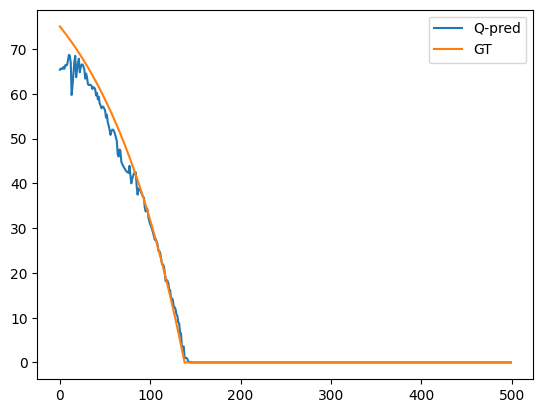

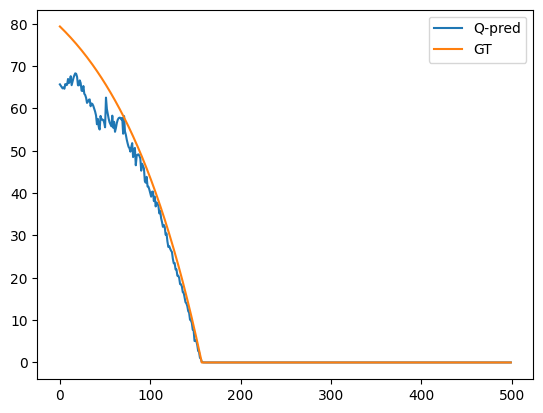

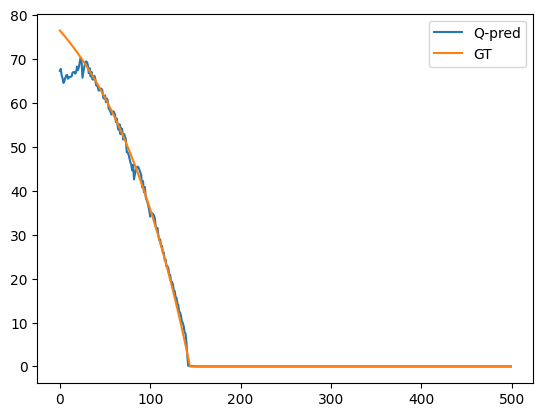

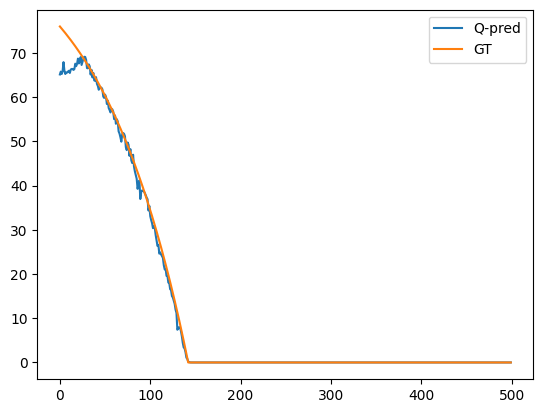

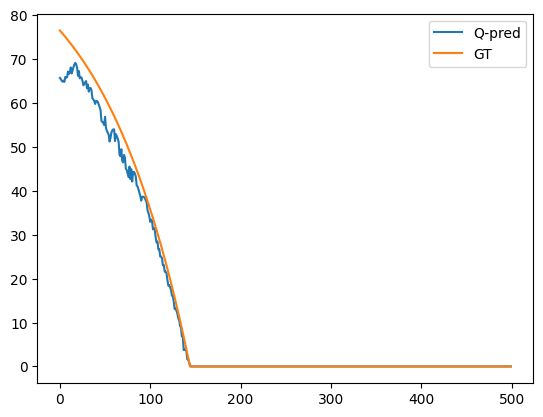

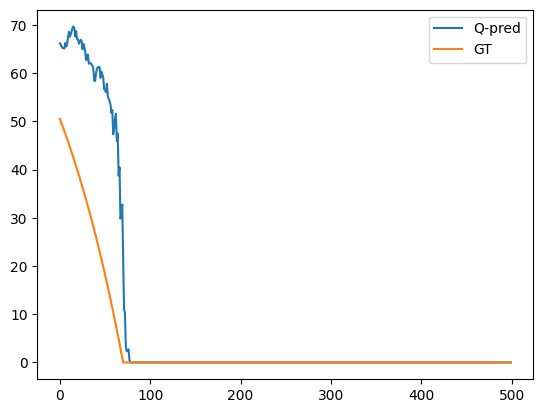

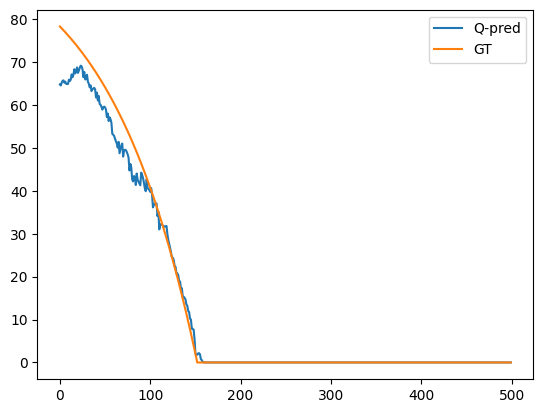

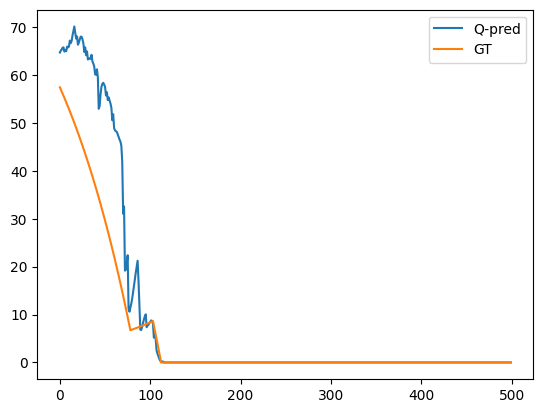

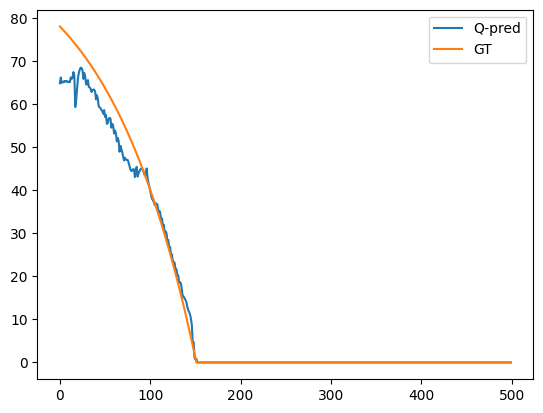

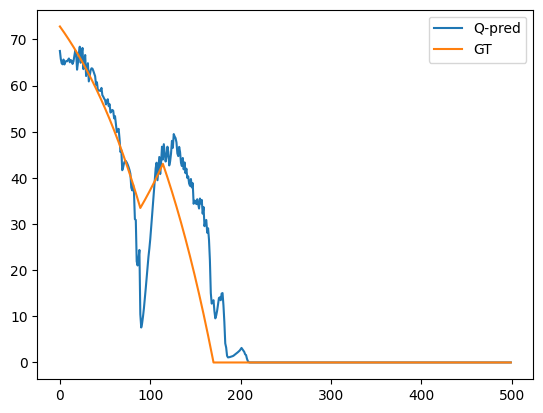

In [76]:
# logged_dataset = train_logged_dataset
# rets = train_rets

logged_dataset = test_logged_dataset
rets = test_rets

for batch_i in range(10):
    start_ind = batch_i * logged_dataset["step_per_trajectory"]
    end_ind = (batch_i + 1) * logged_dataset["step_per_trajectory"]

    sample_inds = np.arange(start_ind, end_ind)
    batch = {
        "observation": {"observation": logged_dataset["state"][sample_inds]},
        "action": np.eye(logged_dataset["n_actions"])[logged_dataset["action"][sample_inds]],
        "reward": logged_dataset["reward"][sample_inds],
        "terminal": logged_dataset["terminal"][sample_inds],
        "return": rets[sample_inds][..., None]
    }

    q_vals, _ = jax.vmap(
        partial(qf.forward, eval=False), in_axes=[0, None, None]
    )(
        model_dict[CONST_MODEL][CONST_QF],
        batch["observation"],
        batch["action"],
    )

    value_error = batch["return"][None] - q_vals

    x_axis = np.arange(logged_dataset["step_per_trajectory"])

    plt.plot(x_axis, q_vals[0, :, 0], label="Q-pred")
    plt.plot(x_axis, batch["return"][:, 0], label="GT")
    plt.legend()
    plt.show()